# Preprocessing

### Setup and Environment

Load the necessary libraries for data manipulation, statistical analysis, and advanced visualization. Setting the visual style ensures consistency across all plots.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='muted')

### Data Loading & Initial Inspection

Load the raw dataset and perform a high-level check of the data structure, column types, and dimensions to identify immediate issues.

In [31]:
df = pd.read_csv('../data/data.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (8957, 363)


,pseudo_id,today,interviewtype,monitor_gender,interview_province,interview_district,site_001,site_type,assessment_modality,are_you_headhh,...,intendinginte_what_are_whys_f_1,intendinginte_what_are_whys_r_1,intendinginte_what_are_whys_c_1,intendinginte_what_are_whys_oth,observed_tension_and,observed_si_dneglect_against__1,observed_si_dneglect_against_pwd,observed_si_dneglect_against__2,observed_si_dneglect_against__3,weight
0,1,2024/04/25 00:00:00,hh,male,BDG,2901,urban,non_settlement,in_person,yes,...,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,5.234111
1,2,2024/07/29 00:00:00,hh,female,FRH,3101,rural,settlement,in_person,yes,...,0.0,0.0,0.0,0.0,no,NaN,NaN,NaN,NaN,1512.902791
2,3,2024/03/06 00:00:00,hh,female,HLD,Other,urban,n_a,on_phone,no,...,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,1512.902791
3,4,2024/11/05 00:00:00,hh,male,WDK,401,rural,n_a,in_person,yes,...,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,508.743824
4,5,2024/01/30 00:00:00,hh,female,HRT,3002,rural,non_settlement,in_person,no,...,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,508.743824


### Advanced Outlier Detection

We implement the Tukey method to identify statistical outliers. We first ensure the data is numeric, as mathematical operations like percentiles cannot be performed on strings or non-numeric categories.

In [32]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        # Step 1: Force numeric conversion (errors='coerce' turns strings into NaN)
        temp_series = pd.to_numeric(df[col], errors='coerce').dropna()
        
        if len(temp_series) == 0:
            continue
            
        # Step 2: Calculate quartiles
        Q1 = np.percentile(temp_series, 25)
        Q3 = np.percentile(temp_series, 75)
        IQR = Q3 - Q1
        
        # Step 3: Determine boundaries
        outlier_step = 1.5 * IQR
        
        # Step 4: Identify indices
        # We apply the logic back to the original column converted to numeric
        numeric_col = pd.to_numeric(df[col], errors='coerce')
        outlier_list_col = numeric_col[(numeric_col < Q1 - outlier_step) | 
                                       (numeric_col > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    # Step 5: Select rows with more than n outliers
    multiple_outliers = list(set([k for k in outlier_indices if outlier_indices.count(k) > n]))
    return multiple_outliers

# Implementation for your specific humanitarian dataset
# Note: 'what_is_sizeyour_famil' often contains strings like '1_5', 
# this code will treat those as NaN to avoid crashing.
features_to_check = ["male_0_6", "female_0_6", "male_7_14", "female_7_14"]
outliers_to_drop = detect_outliers(df, 2, features_to_check)

print(f"Number of rows with multiple outliers to drop: {len(outliers_to_drop)}")

# Drop outliers
# df = df.drop(outliers_to_drop, axis=0).reset_index(drop=True)

Number of rows with multiple outliers to drop: 0


### Missing Values Analysis & Imputation

We visualize the missing data. Following the advanced methodology, we don't just delete columns, we fill numerical gaps with the median and categorical ones with the mode (the most frequent value).

In [33]:
# Ver nulos
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Imputación
# Para números: Mediana
num_vars = df.select_dtypes(include=['int64', 'float64']).columns
for var in num_vars:
    df[var] = df[var].fillna(df[var].median())

# Para categorías: Moda
cat_vars = df.select_dtypes(include=['object']).columns
for var in cat_vars:
    df[var] = df[var].fillna(df[var].mode()[0])

no_why_002_fear_personal_safety    8837
no_why_002_presenceexplosive__1    8837
no_why_002_no_mahram               8837
no_why_002_lackdocumentation       8837
no_why_002_safety_concerns_re_1    8837
no_why_002_discr_exmahr            8837
no_why_002_oth                     8837
return_when                        8768
unablere_issu_whys_intentionm      8758
unablere_issu_whys_concernspe      8758
dtype: int64


### Feature Engineering: Creating New Indicators

We create a 'Total_Family_Size' by summing all age groups and a 'Vulnerability_Score' based on the 'hh_info' columns.

In [34]:
# 1. Tamaño familiar total
family_cols = ['male_0_6', 'male_7_14', 'male_15_17', 'male_18_59', 'male_60',
               'female_0_6', 'female_7_14', 'female_15_17', 'female_18_59', 'female_60']
df['total_family_size'] = df[family_cols].sum(axis=1)

# 2. Índice de vulnerabilidad (Suma de problemas reportados)
vulnerability_cols = [col for col in df.columns if 'hh_info_' in col and 'none' not in col]
df['vulnerability_score'] = df[vulnerability_cols].apply(lambda x: (x == 'yes').sum(), axis=1)

# 3. Simplificación de categorías (Ejemplo: Marital Status)
df['is_married'] = df['marital_status'].map(lambda s: 1 if s == 'married' else 0)

### Correlation Heatmap

We generate a correlation matrix to see how our new features interact. This helps us decide if some variables are redundant (highly correlated) or very important for our target.

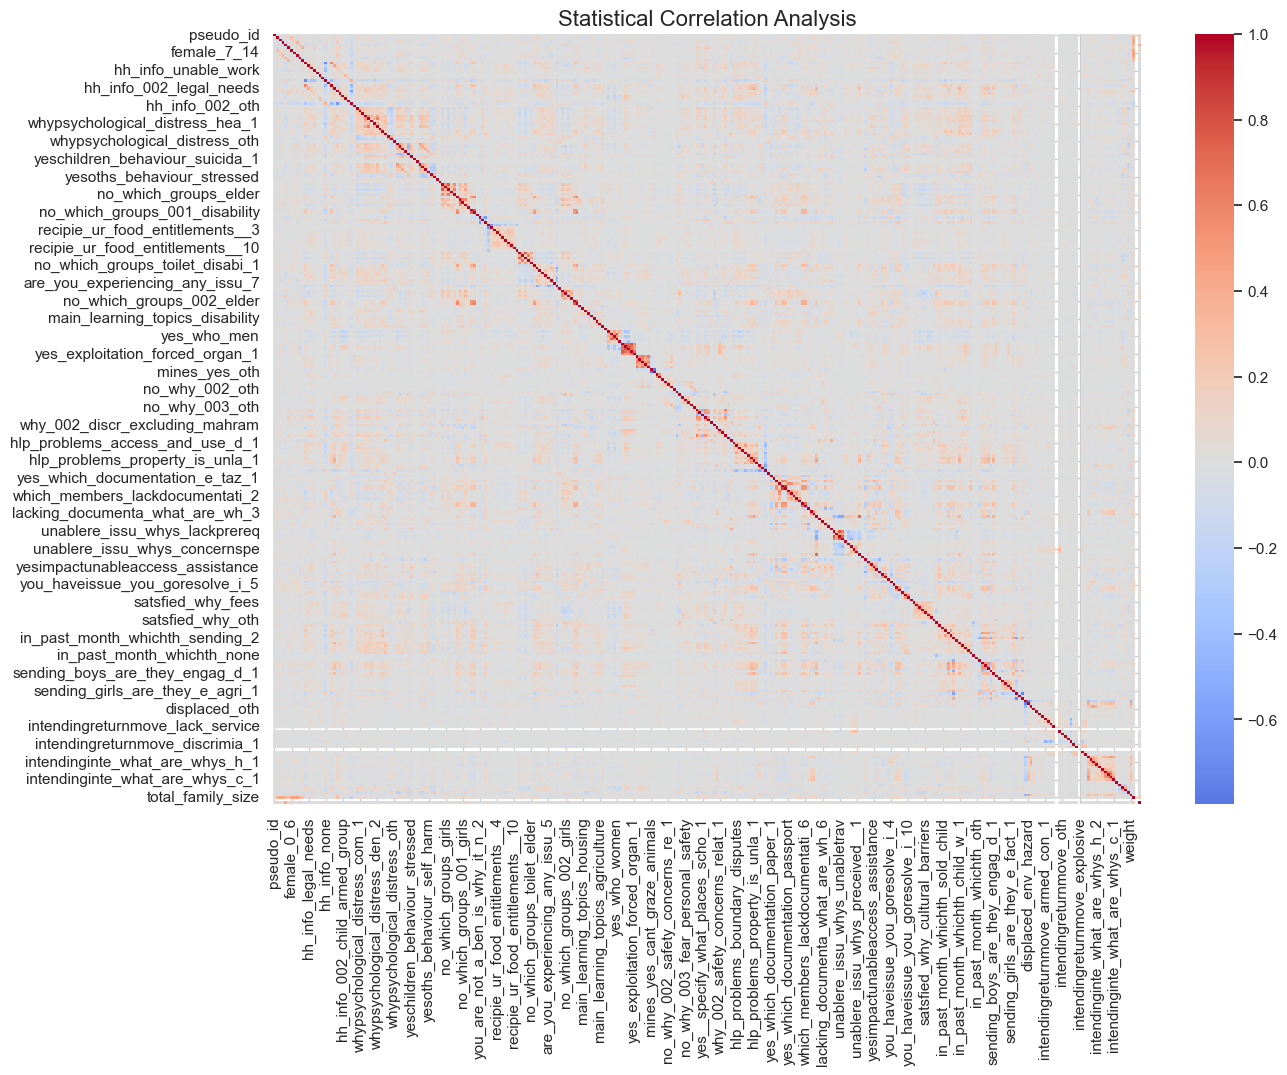

In [35]:
# Filtering numerical data to avoid string conversion errors
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Statistical Correlation Analysis", fontsize=16)
plt.show()

The heatmap displays the Pearson correlation coefficients between numerical features. Values close to 1.0 (dark red) indicate a strong positive relationship, while values close to -1.0 (dark blue) indicate a strong inverse relationship. In this dataset, we observe clusters of high correlation among demographic variables (e.g., family members by age group). This suggests that instead of keeping every individual age/gender column, we can simplify the model by using aggregated totals, reducing redundancy and the 'curse of dimensionality'. Variables with near-zero correlation to our target or other features may be considered for removal to improve model efficiency.

### Feature Selection and Dimensionality Reduction

Based on the correlation analysis, we remove highly redundant features or non-informative identifiers. Keeping columns that provide the same information (multicollinearity) can destabilize certain models. We also drop administrative columns like IDs and dates that do not contribute to the predictive power of the statistical model.

In [36]:
# Drop administrative and redundant columns identified in the heatmap
cols_to_drop = ['pseudo_id', 'today', 'district', 'site_001'] 
df_reduced = df.drop(columns=cols_to_drop, errors='ignore')

print(f"Features reduced from {df.shape[1]} to {df_reduced.shape[1]}")

Features reduced from 366 to 362


### Categorical Variable Transformation (Encoding)

Since machine learning algorithms require numerical input, we transform categorical text data. We apply One-Hot Encoding to nominal variables (like 'status' or 'province') to create binary indicators. This process ensures that the model does not assume an artificial mathematical order between different categories.

In [37]:
# Identify categorical columns
categorical_cols = df_reduced.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding
df_final = pd.get_dummies(df_reduced, columns=categorical_cols, drop_first=True)

print(f"Final dataset shape after encoding: {df_final.shape}")

Final dataset shape after encoding: (8957, 537)


### Feature Scaling and Normalization

Numerical features often have vastly different scales (e.g., family size vs. population counts). We apply Standardization to shift the distribution of each feature to have a mean of zero and a unit standard deviation. This step is critical for ensuring that the model assigns importance based on the data's signal rather than the magnitude of the numbers.

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scaling all features to a standard normal distribution
scaled_features = scaler.fit_transform(df_final)

# Re-creating the DataFrame with scaled values
df_preprocessed = pd.DataFrame(scaled_features, columns=df_final.columns)
df_preprocessed.head()

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,...,idp_do_you_inten_tionmove_onward_move_onward,idp_do_you_inten_tionmove_onward_not_sure,idp_do_you_inten_tionmove_onward_return,returnee_refugee_when_did_you_1_1__years,returnee_refugee_when_did_you_1_3__years,returnee_refugee_when_did_you_1_4_12_months,return_when_1__years,return_when_3__years,return_when_4_12_months,observed_tension_and_yes
0,0.725544,0.730391,-0.894854,0.467412,-0.367351,-1.195553,0.767074,1.007733,0.354108,-0.335047,...,-0.103537,-0.282271,-0.146818,-0.772223,-0.767441,2.146775,0.119448,-0.071848,-0.067812,-0.502894
1,0.725544,0.730391,-0.894854,0.467412,-0.367351,0.836433,-1.303656,-0.992326,0.354108,-0.335047,...,-0.103537,-0.282271,-0.146818,-0.772223,1.303032,-0.465815,0.119448,-0.071848,-0.067812,-0.502894
2,-1.378276,0.730391,1.117501,-2.139442,-0.367351,-1.195553,0.767074,1.007733,0.354108,-0.335047,...,-0.103537,3.542694,-0.146818,-0.772223,-0.767441,2.146775,0.119448,-0.071848,-0.067812,-0.502894
3,-1.378276,-1.369131,1.117501,0.467412,2.722192,0.836433,0.767074,1.007733,0.354108,-0.335047,...,-0.103537,-0.282271,-0.146818,-0.772223,1.303032,-0.465815,0.119448,-0.071848,-0.067812,-0.502894
4,-1.378276,-1.369131,-0.894854,0.467412,2.722192,-1.195553,0.767074,1.007733,0.354108,-0.335047,...,-0.103537,-0.282271,-0.146818,-0.772223,-0.767441,-0.465815,0.119448,-0.071848,-0.067812,-0.502894


### Data Splitting for Model Validation

The final step in the preprocessing pipeline is to partition the data into Training and Testing sets. This allows us to train the model on one portion of the data and validate its predictive accuracy on a separate, unseen 'hold-out' set. This practice is essential to detect overfitting and ensure the model's reliability in real-world scenarios.

In [39]:
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
# Replace 'target_column' with your actual label
X = df_preprocessed.drop('target_column', axis=1, errors='ignore')
y = df_preprocessed['target_column'] if 'target_column' in df_preprocessed else None

if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split successfully: 80% Training / 20% Testing")